In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cobra
from cobra.io import read_sbml_model, write_sbml_model
from cobra.flux_analysis import flux_variability_analysis
from tqdm import tqdm

In [53]:
class Predation:
    def dynamic_metabolite(
        self, model: cobra.core.model.Model, metabolites: dict
    ) -> dict:
        """Convert the classic metabolites name into reaction used by the model. \n
        :param Model model: The model you want to used. \n
        :param dict y: A dictionary of the metabolite and their quantities in environment. ex: {Biomass: 100}
        """
        # convert to metabolites id
        Metabolites_id = {}
        for i in model.metabolites:
            for j in metabolites:
                if j in i.name:  # check metabolites name
                    Metabolites_id[i.id] = j  # save its id if have metabolites in name

        # convert to reaction id
        FBA1 = model.optimize()  # perform FBA
        reaction_id = {}

        for i in model.exchanges._dict:  # filter for only exchange reaction
            for j in Metabolites_id:
                if (
                    j in model.reactions.get_by_id(i).reaction and i not in reaction_id
                ):  # check if metabolites in reaction and if not already added
                    if FBA1[i] < 0:
                        reaction_id[i] = Metabolites_id[j]  # add the reaction id

        return reaction_id

    def add_dynamic_bounds(
        self, model: cobra.core.model.Model, y: dict, dico: dict, biomass: float
    ) -> None:
        """Use external concentrations to change the bound changing the uptake flux of the limited metabolites. \n
        :param Model model: The model you want to add dynamic bounds. \n
        :param dict y: A list of the metabolite quantities in environment. \n
        :param dict dico: A dictionary of the reaction \n
        :param int biomass: Quantities of Biomass in the environment.
        """
        for i in dico:
            model.reactions.get_by_id(i).lower_bound = (
                -10 * y[dico[i]] / (5 + y[dico[i]])
            )  # change the max import value for the metabolites

        biomass_max_import = -10 * biomass / (5 + biomass)

        self.pred.reactions.EX_glc_D_e.bounds = [0, 0]
        self.pred.reactions.EX_Biomass_e.lower_bound = biomass_max_import

    def update_metabolites(
        self, fluxes: list, y: dict, dico: dict, biomass: int
    ) -> dict:
        """Updtate the metabolites quantities depending of the fluxes. \n
        :param list(int) fluxes: The list of the fluxes. \n
        :param dict y: A list of the metabolite quantities in environment. \n
        :param dict dico: A dictionary of the reaction \n
        :param int biomass: Quantities of Biomass in the environment.
        """
        for i in dico:
            y[dico[i]] = (
                y[dico[i]] + fluxes[i] * biomass
            )  # calculate the number of metabolites
            if y[dico[i]] < 0:
                y[dico[i]] = (
                    0  # if the value goes below zero set the number of metaboltie to zero
                )

        return y

    def update_biomass(
        self, fluxes_1: list, fluxes_2: list, it: float
    ) -> tuple[dict, dict]:
        """Updtate the metabolites quantities depending of the fluxes. \n
        :param list(int) fluxes_1: The list of the fluxes of the prey. \n
        :param list(int) fluxes_2: The list of the fluxes of the predator. \n
        :param float it: the number of loop done. \n
        """
        if (
            self.Biomass_Prey[it - 1]
            + fluxes_1["BIOMASS_Ec_iML1515_core_75p37M"] * self.Biomass_Prey[it - 1]
            + fluxes_2["EX_Biomass_e"] * self.Biomass_Pred[it - 1]
            < 0
        ):
            self.Biomass_Prey.append(0)
        else:
            self.Biomass_Prey.append(
                self.Biomass_Prey[it - 1]
                + fluxes_1["BIOMASS_Ec_iML1515_core_75p37M"] * self.Biomass_Prey[it - 1]
                + fluxes_2["EX_Biomass_e"] * self.Biomass_Pred[it - 1]
            )

        self.Biomass_Pred.append(
            self.Biomass_Pred[it - 1]
            + fluxes_2["OF_BIOMASS"] * self.Biomass_Pred[it - 1]
        )

        return self.Biomass_Prey, self.Biomass_Pred

    def add_predation(self) -> None:
        """Add the predation reaction and the exchange reaction of Biomass to the predator model."""
        Biomass_e = cobra.Metabolite(
            "Biomass_e", formula="BIOMASS", name="Biomass [e]", compartment="e"
        )

        self.pred.add_metabolites(Biomass_e)  # add self.pred.metabolites.Biomass_e

        self.pred.add_boundary(
            self.pred.metabolites.get_by_id("Biomass_e"), type="exchange"
        )  # add the exchange reaction for Biomass_e

        Mreaction = cobra.Reaction("PR_BIOMASS")
        Mreaction.name = "Predation Biomass"
        Mreaction.subsystem = ""
        Mreaction.lower_bound = 0.0  # This is the default
        Mreaction.upper_bound = 1000.0  # This is the default

        Biomass_e = self.pred.metabolites.Biomass_e

        spmd_e = (
            self.pred.metabolites.spmd_e
        )  # carbon source from exchange used in biomass reaction
        pheme_e = self.pred.metabolites.pheme_e
        val_L_e = self.pred.metabolites.val_L_e  # imported AA
        ile_L_e = self.pred.metabolites.ile_L_e
        leu_L_e = self.pred.metabolites.leu_L_e
        lys_L_e = self.pred.metabolites.lys_L_e
        his_L_e = self.pred.metabolites.his_L_e
        gly_cys_L_e = self.pred.metabolites.gly_cys_L_e
        cgly_e = self.pred.metabolites.cgly_e
        pro_L_e = self.pred.metabolites.pro_L_e
        alaala_e = self.pred.metabolites.alaala_e
        glu_L_c = self.pred.metabolites.glu_L_c
        met_L_e = self.pred.metabolites.met_L_e
        thr_L_e = self.pred.metabolites.thr_L_e
        fru_e = self.pred.metabolites.fru_e  # import fructose
        man_e = self.pred.metabolites.man_e
        # malt_e = self.pred.metabolites.malt_e
        acald_e = self.pred.metabolites.acald_e  # import FA
        acac_e = self.pred.metabolites.acac_e
        # glyc3p_e = self.pred.metabolites.glyc3p_e
        # gam_e = self.pred.metabolites.gam_e
        fum_e = (
            self.pred.metabolites.fum_e
        )  # should put directly the amino acids? asp and arg?
        orn_e = self.pred.metabolites.orn_e
        # succ_e = self.pred.metabolites.succ_e
        pi_e = self.pred.metabolites.pi_e  # from research
        zn2_e = self.pred.metabolites.zn2_e  # Metals
        mn2_e = self.pred.metabolites.mn2_e
        mg2_e = self.pred.metabolites.mg2_e
        k_e = self.pred.metabolites.k_e
        cu2_e = self.pred.metabolites.cu2_e
        cobalt2_e = self.pred.metabolites.cobalt2_e
        cl_e = self.pred.metabolites.cl_e
        ca2_e = self.pred.metabolites.ca2_e
        so4_e = self.pred.metabolites.so4_e
        fe3_e = self.pred.metabolites.Fe3_e

        # adocbl_e = self.pred.metabolites.adocbl_e # not used at all

        Mreaction.add_metabolites(
            {
                Biomass_e: -1,
                spmd_e: 1,
                pheme_e: 1,
                val_L_e: 1,
                ile_L_e: 1,
                leu_L_e: 1,
                lys_L_e: 1,
                his_L_e: 1,
                gly_cys_L_e: 1,
                cgly_e: 1,
                pro_L_e: 1,
                alaala_e: 1,
                fru_e: 1,
                man_e: 1,
                # malt_e: 1,
                glu_L_c: 1,
                met_L_e: 1,
                thr_L_e: 1,
                # gam_e: 1,
                fum_e: 1,
                orn_e: 1,
                # succ_e: 1,
                acald_e: 1,
                acac_e: 1,
                # glyc3p_e: 1,
                pi_e: 1,
                zn2_e: 1,
                mn2_e: 1,
                mg2_e: 1,
                k_e: 1,
                cu2_e: 1,
                cobalt2_e: 1,
                cl_e: 1,
                ca2_e: 1,
                so4_e: 1,
                fe3_e: 1,
                # adocbl_e:1
            }
        )  # add the metabolites to the reaction

        Mreaction.gene_reaction_rule = ""  # define which gene allow the reaction
        self.pred.add_reactions([Mreaction])  # add the PR_Biomass reaction
        self.pred.reactions.PR_BIOMASS

        self.pred.reactions.EX_spmd_e.lower_bound = 0  # define the bound to 0 for metabolites in the reactions  # ? - not imported by E.coli / used for Biomass
        self.pred.reactions.EX_pheme_e.lower_bound = (
            0  # amino acid - from Data / not imported by E.coli
        )
        self.pred.reactions.EX_val_L_e.lower_bound = 0  # amino acid - from Data
        self.pred.reactions.EX_ile_L_e.lower_bound = 0  # amino acid - from Data
        self.pred.reactions.EX_leu_L_e.lower_bound = 0  # amino acid - from Data
        self.pred.reactions.EX_lys_L_e.lower_bound = 0  # amino acid
        self.pred.reactions.EX_gly_cys_L_e.lower_bound = 0  # amino acid - from Data
        self.pred.reactions.EX_cgly_e.lower_bound = 0  # amino acid - from Data
        self.pred.reactions.EX_pro_L_e.lower_bound = 0  # amino acid - from Data
        self.pred.reactions.EX_alaala_e.lower_bound = 0  # amino acid
        self.pred.reactions.EX_glu_L_e.lower_bound = 0  # amino acid
        self.pred.reactions.EX_met_L_e.lower_bound = 0  # amino acid - from Data
        self.pred.reactions.EX_thr_L_e.lower_bound = 0  # amino acid
        self.pred.reactions.EX_fru_e.lower_bound = 0  # sugar - from data / article
        self.pred.reactions.EX_man_e.lower_bound = 0  # sugar - from data / article
        # self.pred.reactions.EX_malt_e.lower_bound = 0
        self.pred.reactions.EX_acald_e.lower_bound = 0  # FA - from article
        self.pred.reactions.EX_acac_e.lower_bound = 0  # FA - from article
        # self.pred.reactions.EX_glyc3p_e.lower_bound = 0
        # self.pred.reactions.EX_gam_e.lower_bound = 0
        self.pred.reactions.EX_fum_e.lower_bound = 0
        self.pred.reactions.EX_orn_e.lower_bound = 0
        # self.pred.reactions.EX_succ_e.lower_bound = 0
        # self.pred.reactions.EX_pi_e.lower_bound = 0 # phosphate - from Data / in env
        # self.pred.reactions.EX_zn2_e.lower_bound = 0 # Metals - from Data / in env
        # self.pred.reactions.EX_mn2_e.lower_bound = 0 # Metals - from Data / in env
        # self.pred.reactions.EX_mg2_e.lower_bound = 0 # Metals - from Data / in env
        # self.pred.reactions.EX_k_e.lower_bound = 0 # Metals - from Data / in env
        # self.pred.reactions.EX_cu2_e.lower_bound = 0 # Metals - from Data / in env
        # self.pred.reactions.EX_cobalt2_e.lower_bound = 0 # Metals - from Data / in env
        # self.pred.reactions.EX_cl_e.lower_bound = 0 # Metals - from Data / in env
        # self.pred.reactions.EX_ca2_e.lower_bound = 0 # Metals - from Data / in env
        # self.pred.reactions.EX_so4_e.lower_bound = 0 # sulfate - not imported by E.coli / in env
        # self.pred.reactions.EX_Fe3_e.lower_bound = 0 # Metals - from data ? in env
        # self.pred.reactions.EX_adocbl_e.lower_bound = 0

    def run(self) -> None:
        """Run the flux balance analysis with predation between the prey and the predator."""
        dico1 = self.dynamic_metabolite(self.prey, self.metabolite)
        dico2 = self.dynamic_metabolite(self.pred, self.metabolite)

        self.fluxes_prey = []
        self.fluxes_pred = []
        self.time_point = [0]
        t = 0
        it = 1

        self.Biomass_Pred = [0.01]
        self.Biomass_Prey = [0.01]  # quantity of biomass in environment

        with tqdm(total=self.tf) as pbar:
            while t < self.tf:
                self.add_dynamic_bounds(
                    self.prey, self.metabolite, dico1, self.Biomass_Prey[it - 1]
                )  ## For Escherichia coli
                FBA_1 = self.prey.optimize()  # perform flux balance analysis (FBA)
                fluxes_1 = FBA_1.fluxes.get(
                    self.reactions_list_prey
                )  # store the fluxes of the FBA
                fluxes_1 *= 0.1  # multiply by Biomass Concentration to get flux
                self.fluxes_prey.append(fluxes_1)  # store all the fluxes
                self.metabolite = self.update_metabolites(
                    fluxes_1, self.metabolite, dico1, self.Biomass_Prey[it - 1]
                )

                self.add_dynamic_bounds(
                    self.pred, self.metabolite, dico2, self.Biomass_Prey[it - 1]
                )  ## For Myxococcus xanthus
                FBA_2 = self.pred.optimize()
                fluxes_2 = FBA_2.fluxes.get(self.reactions_list_pred)
                fluxes_2 *= 0.1
                self.fluxes_pred.append(fluxes_2)
                self.metabolite = self.update_metabolites(
                    fluxes_2, self.metabolite, dico2, self.Biomass_Pred[it - 1]
                )

                self.Biomass_Prey, self.Biomass_Pred = self.update_biomass(
                    fluxes_1, fluxes_2, it
                )

                self.time_point.append(self.time_point[it - 1] + self.steps)
                it += 1
                t += self.steps
                pbar.update(self.steps)

    def plot_flux(self) -> None:
        """Plot the fluxes of biomass of the prey against the predator"""
        self.run()  # Run the predator interaction

        biomass_prey = []
        biomass_pred = []

        for i in self.fluxes_pred:
            biomass_pred.append(i["OF_BIOMASS"])  # taking the biomass flux
        for j in self.fluxes_prey:
            biomass_prey.append(j["BIOMASS_Ec_iML1515_core_75p37M"])

        ax = plt.subplot(111)
        ax.plot(
            self.time_point[1:], biomass_prey, color="blue", label="Prey"
        )  # plot the biomass flux of E_coli
        ax2 = plt.twinx(ax)
        ax2.plot(self.time_point[1:], biomass_pred, color="red", label="Preda")

        ax.set_ylabel("Biomass", color="blue")  # set the name
        ax2.set_ylabel("Biomass", color="red")
        ax.set_xlabel("Time")

        ax.set_title(
            "Fluxes of the biomass from E.coli against M.xanthus"
        )  # set the title
        ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")  # show the legend
        ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")

    def plot_biomass(self) -> None:
        """Plot of biomass of the prey against the predator"""
        self.run()  # Run the predator interaction

        ax = plt.subplot(111)
        ax.plot(
            self.time_point[1:], self.Biomass_Prey[1:], color="blue", label="Prey"
        )  # plot the biomass flux of E_coli
        ax2 = plt.twinx(ax)
        ax2.plot(
            self.time_point[1:], self.Biomass_Pred[1:], color="red", label="Predator"
        )

        ax.set_ylabel("Biomass", color="blue")  # set the name
        ax2.set_ylabel("Biomass", color="red")
        ax.set_xlabel("Time")

        ax.set_title("Biomass of E.coli against M.xanthus")  # set the title
        ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")  # show the legend
        ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")

    def __init__(
        self,
        prey: cobra.core.model.Model,
        pred: cobra.core.model.Model,
        metabolite: dict,
        tf: float = 50,
        dt: float = 0.5,
    ) -> None:
        self.prey = prey
        self.pred = pred
        self.add_predation()
        self.metabolite = metabolite
        self.tf = tf
        self.steps = dt

        self.reactions_list_prey = []  # get all reaction of E_coli model
        for reaction in self.prey.reactions:
            self.reactions_list_prey.append(reaction.id)

        self.reactions_list_pred = []
        for reaction in self.pred.reactions:
            self.reactions_list_pred.append(reaction.id)

In [54]:
M_xanthus = read_sbml_model("../M_xanthus_model_V2.sbml")
E_coli = read_sbml_model("../E_coli_model.sbml")
metabolites = {"Glucose": 100, "Ammonium": 100}

In [55]:
Preda = Predation(E_coli, M_xanthus, metabolites, tf=40)

100%|██████████| 40.0/40 [00:12<00:00,  3.32it/s]


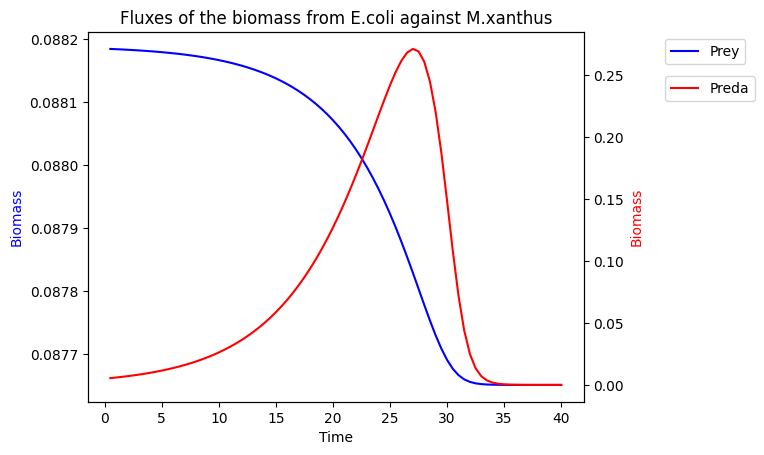

In [56]:
Preda.plot_flux()

100%|██████████| 40.0/40 [00:11<00:00,  3.41it/s]


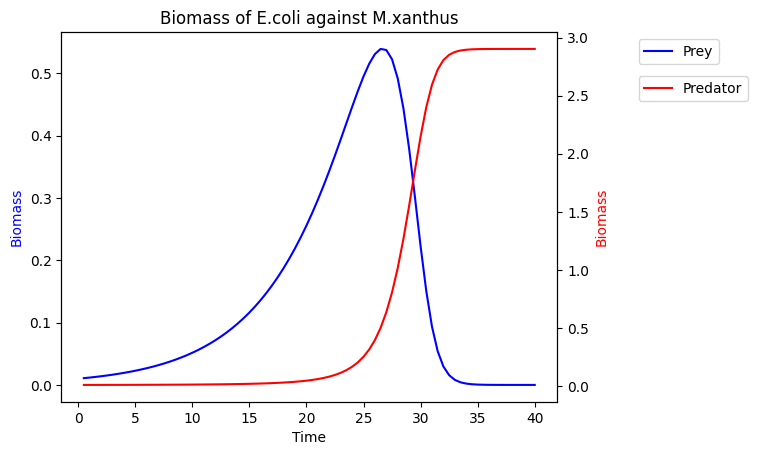

In [57]:
Preda.plot_biomass()